# My data analysis

In [61]:
# import libraries
import numpy as np
import pandas as pd
import glob
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [62]:
CO2_data = pd.read_feather('./../Data/CO2/CO2_01_2022.feather')
CO2_data

Time    C11    C13    C21    C23    C31    C33  \
0    2022-01-01 10:05:00+00:00  409.0  408.0  410.0  409.0  420.0  424.0   
1    2022-01-01 10:10:00+00:00  409.0  407.0  410.0  409.0  420.0  424.0   
2    2022-01-01 10:15:00+00:00  410.0  407.0  410.0  408.0  419.0  424.0   
3    2022-01-01 10:20:00+00:00  410.0  407.0  411.0  408.0  419.0  424.0   
4    2022-01-01 10:25:00+00:00  410.0  407.0  411.0  408.0  419.0  424.0   
...                        ...    ...    ...    ...    ...    ...    ...   
8219 2022-01-31 23:35:00+00:00  428.0  430.0  426.0  425.0    NaN    NaN   
8220 2022-01-31 23:40:00+00:00  428.0  429.0  426.0  425.0    NaN    NaN   
8221 2022-01-31 23:45:00+00:00  427.0  429.0  425.0  425.0    NaN    NaN   
8222 2022-01-31 23:50:00+00:00  427.0  428.0  423.0  425.0    NaN    NaN   
8223 2022-01-31 23:55:00+00:00  427.0  428.0  423.0  425.0    NaN    NaN   

        C35    C36  
0     420.0  422.0  
1     420.0  422.0  
2     420.0  422.0  
3     419.0  422.0  
4     419.0  422.0  
...     ...    ...  
8219    NaN    NaN  
8220    NaN    NaN  
8221    NaN    NaN  
8222    NaN    NaN  
8223    NaN    NaN  

[8224 rows x 9 columns]

This is the observation about the data....



# 1.Visuallization and missing points recording

2022: 8224 records
2023: 5789 records
2024: 7407 records


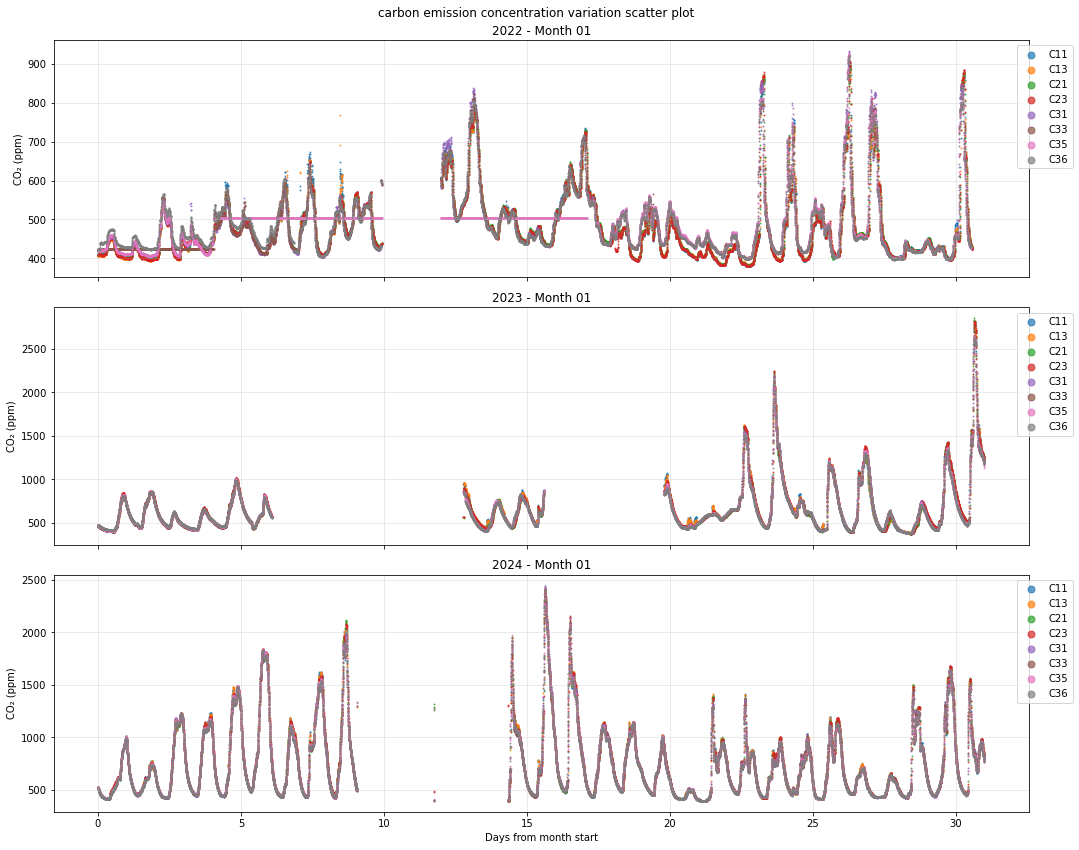

In [63]:
#define a function for plotting comparison over three years
def plot_month_comparison_scatter(month):
    years = ["2022", "2023", "2024"]
    
    # data loading
    data = {}
    for year in years:
        try:
            df = pd.read_feather(f"../Data/CO2/CO2_{month}_{year}.feather")
            data[year] = df
            print(f"{year}: {len(df)} records")
        except:
            print(f"{year}: No data")
            data[year] = None
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    co2_sensors = ['C11', 'C13', 'C21', 'C23', 'C31', 'C33', 'C35', 'C36']
    
    for i, year in enumerate(years):
        if data[year] is not None:
            df = data[year]
            start_time = df['Time'].min()
            days = (df['Time'] - start_time).dt.total_seconds() / (24 * 3600)
            
            for sensor in co2_sensors:
                if sensor in df.columns:
                    valid_mask = df[sensor].notna()
                    axes[i].scatter(days[valid_mask], df[sensor][valid_mask], 
                                  label=sensor, alpha=0.7, s=1)  # s=1 means small points
            
            axes[i].set_title(f'{year} - Month {month}')
            axes[i].set_ylabel('CO₂ (ppm)')
            axes[i].legend(bbox_to_anchor=(1.05, 1),markerscale=7)
            axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Days from month start')
    plt.suptitle(f'carbon emission concentration variation scatter plot')
    plt.tight_layout()
    plt.show()

# test
plot_month_comparison_scatter("01")

It can be seen that there are obvious missing data gap. To further process the data, the overall missing rate of each sensor and time period should be recoreded first.

In [64]:
#define a function to detect the missing data(nan and time gap) and corrospondng time
def analyze_missing_comprehensive(month):
    years = ["2022", "2023", "2024"]
    co2_columns = ['C11', 'C13', 'C21', 'C23', 'C31', 'C33', 'C35', 'C36']
    
    print(f"\n=== Month {month} ===")
    
    for year in years:
        try:
            df = pd.read_feather(f"../Data/CO2/CO2_{month}_{year}.feather")
            df['Time'] = pd.to_datetime(df['Time'])
            df = df.sort_values('Time')
            
            print(f"\n{year}:")
            
            # 1. NaN missing
            nan_found = False
            for sensor in co2_columns:
                missing_count = df[sensor].isnull().sum()
                if missing_count > 0:
                    nan_found = True
                    missing_rate = missing_count/len(df)*100
                    missing_indices = df[df[sensor].isnull()].index.tolist()
                    start_time = df.loc[missing_indices[0], 'Time'].strftime("%m-%d %H:%M")
                    end_time = df.loc[missing_indices[-1], 'Time'].strftime("%m-%d %H:%M")
                    print(f"  {sensor}:  {missing_rate:.1f}% NaN, occurs between({start_time} to {end_time})")
            
            # 2. time gap
            time_diff = df['Time'].diff()
            large_gaps = time_diff[time_diff > pd.Timedelta(minutes=7.5)]
            
            if len(large_gaps) > 0:
                print(f"  Time gaps: {len(large_gaps)} found")
                for i, (idx, gap) in enumerate(large_gaps.head(3).items()):
                    prev_time = df.iloc[idx-1]['Time']
                    curr_time = df.iloc[idx]['Time'] 
                    gap_hours = gap.total_seconds() / 3600
                    print(f"  {prev_time.strftime('%m-%d %H:%M')} -> {curr_time.strftime('%m-%d %H:%M')} ({gap_hours:.1f}h)")
            
            #if no missing data
            if not nan_found and len(large_gaps) == 0:
                print("  No missing data")
                        
        except FileNotFoundError:
            print(f"\n{year}: No data")
        except Exception as e:print(f"\n{year}: Error - {e}")

#test
analyze_missing_comprehensive('01')


=== Month 01 ===

2022:
  C31:  0.2% NaN, occurs between(01-31 22:55 to 01-31 23:55)
  C33:  0.2% NaN, occurs between(01-31 22:50 to 01-31 23:55)
  C35:  0.2% NaN, occurs between(01-31 22:50 to 01-31 23:55)
  C36:  0.2% NaN, occurs between(01-31 22:55 to 01-31 23:55)
  Time gaps: 3 found
  01-05 10:35 -> 01-05 11:00 (0.4h)
  01-07 15:50 -> 01-07 16:00 (0.2h)
  01-11 08:10 -> 01-13 09:45 (49.6h)

2023:
  C13:  0.0% NaN, occurs between(01-01 05:45 to 01-01 05:45)
  Time gaps: 2 found
  01-07 01:55 -> 01-13 18:40 (160.8h)
  01-16 14:05 -> 01-20 19:05 (101.0h)

2024:
  C13:  0.0% NaN, occurs between(01-31 23:55 to 01-31 23:55)
  C31:  0.0% NaN, occurs between(01-31 23:55 to 01-31 23:55)
  C33:  0.0% NaN, occurs between(01-31 23:50 to 01-31 23:55)
  C35:  0.0% NaN, occurs between(01-31 23:55 to 01-31 23:55)
  C36:  0.0% NaN, occurs between(01-31 23:50 to 01-31 23:55)
  Time gaps: 2 found
  01-10 01:10 -> 01-12 18:15 (65.1h)
  01-12 18:20 -> 01-15 08:15 (61.9h)


# Month 2

2022: 8066 records
2023: 7864 records
2024: 8353 records


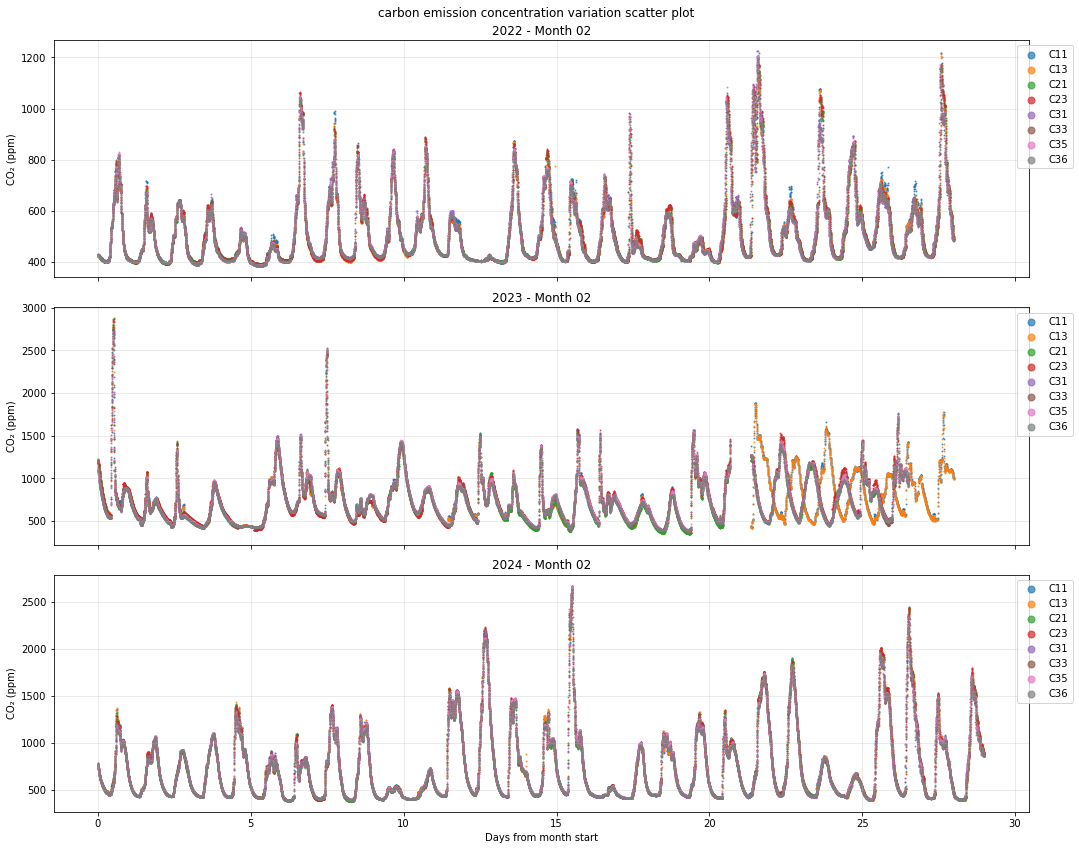


=== Month 02 ===

2022:
  C13:  0.0% NaN, occurs between(02-28 23:55 to 02-28 23:55)
  C31:  0.1% NaN, occurs between(02-28 23:05 to 02-28 23:55)
  C33:  0.1% NaN, occurs between(02-28 23:05 to 02-28 23:55)
  C35:  0.1% NaN, occurs between(02-28 23:15 to 02-28 23:55)
  C36:  0.1% NaN, occurs between(02-28 23:25 to 02-28 23:55)

2023:
  C13:  0.0% NaN, occurs between(02-21 16:20 to 02-28 23:55)
  C21:  5.5% NaN, occurs between(02-05 18:40 to 02-28 23:55)
  C23:  5.4% NaN, occurs between(02-27 12:20 to 02-28 23:55)
  C31:  5.4% NaN, occurs between(02-27 12:20 to 02-28 23:55)
  C33:  5.5% NaN, occurs between(02-27 12:15 to 02-28 23:55)
  C35:  5.4% NaN, occurs between(02-19 09:00 to 02-28 23:55)
  C36:  5.5% NaN, occurs between(02-27 12:15 to 02-28 23:55)
  Time gaps: 10 found
  02-03 08:35 -> 02-03 08:45 (0.2h)
  02-04 08:35 -> 02-04 08:45 (0.2h)
  02-05 08:35 -> 02-05 08:45 (0.2h)

2024:
  C31:  0.0% NaN, occurs between(02-29 23:45 to 02-29 23:55)
  C33:  0.1% NaN, occurs between(02-29

In [50]:
plot_month_comparison_scatter("02")
analyze_missing_comprehensive("02") 

# Month 3

2022: 4114 records
2023: 8914 records
2024: 8918 records


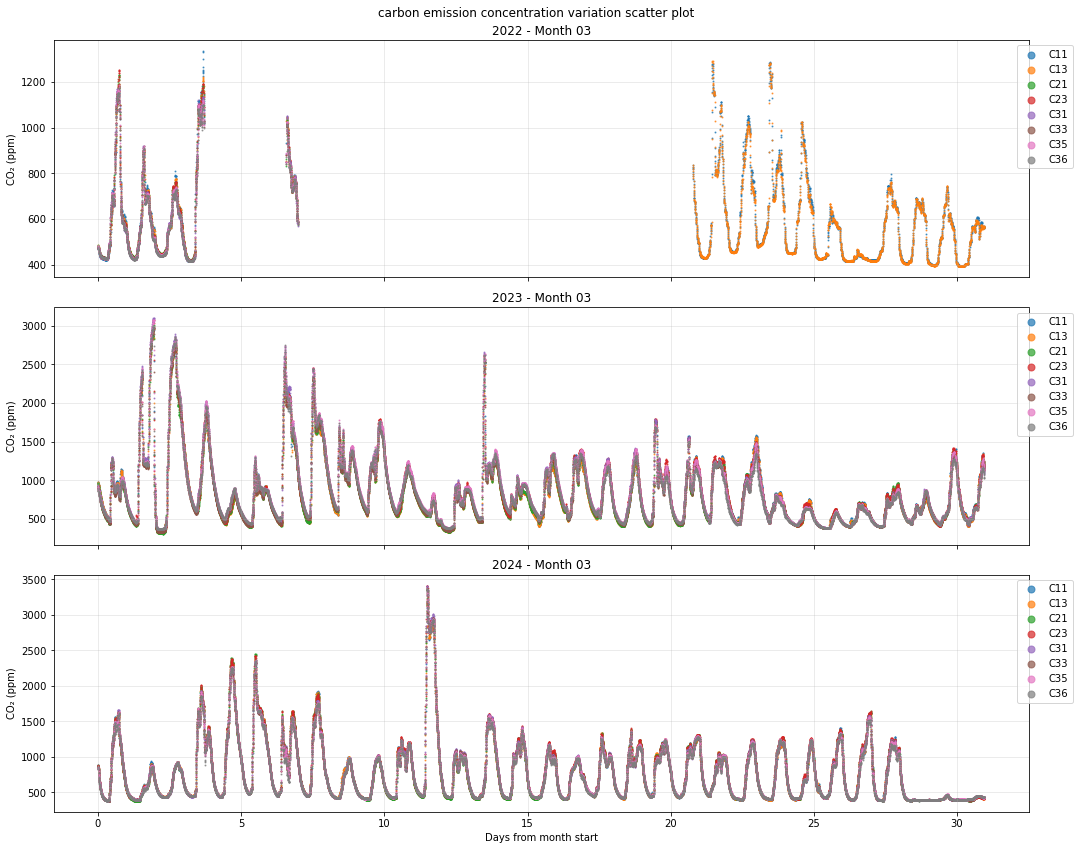


=== Month 03 ===

2022:
  C13:  0.0% NaN, occurs between(03-21 18:30 to 03-31 23:00)
  C21:  71.3% NaN, occurs between(03-21 18:30 to 03-31 23:00)
  C23:  71.3% NaN, occurs between(03-21 18:30 to 03-31 23:00)
  C31:  71.3% NaN, occurs between(03-21 18:30 to 03-31 23:00)
  C33:  71.3% NaN, occurs between(03-21 18:30 to 03-31 23:00)
  C35:  71.3% NaN, occurs between(03-21 18:30 to 03-31 23:00)
  C36:  71.3% NaN, occurs between(03-21 18:30 to 03-31 23:00)
  Time gaps: 7 found
  03-04 16:45 -> 03-07 13:45 (69.0h)
  03-07 13:45 -> 03-07 13:55 (0.2h)

2022: Error - single positional indexer is out-of-bounds

2023:
  C13:  0.0% NaN, occurs between(03-31 22:55 to 03-31 22:55)
  C31:  0.0% NaN, occurs between(03-31 22:55 to 03-31 22:55)
  C33:  0.0% NaN, occurs between(03-12 10:15 to 03-12 10:15)
  C36:  0.0% NaN, occurs between(03-31 22:55 to 03-31 22:55)
  Time gaps: 4 found
  03-28 00:55 -> 03-28 01:05 (0.2h)
  03-29 00:55 -> 03-29 01:05 (0.2h)
  03-30 00:55 -> 03-30 01:05 (0.2h)

2024:
  C

In [51]:
plot_month_comparison_scatter("03")
analyze_missing_comprehensive("03") 

# Month 4

2022: 8641 records
2023: 8640 records
2024: 8634 records


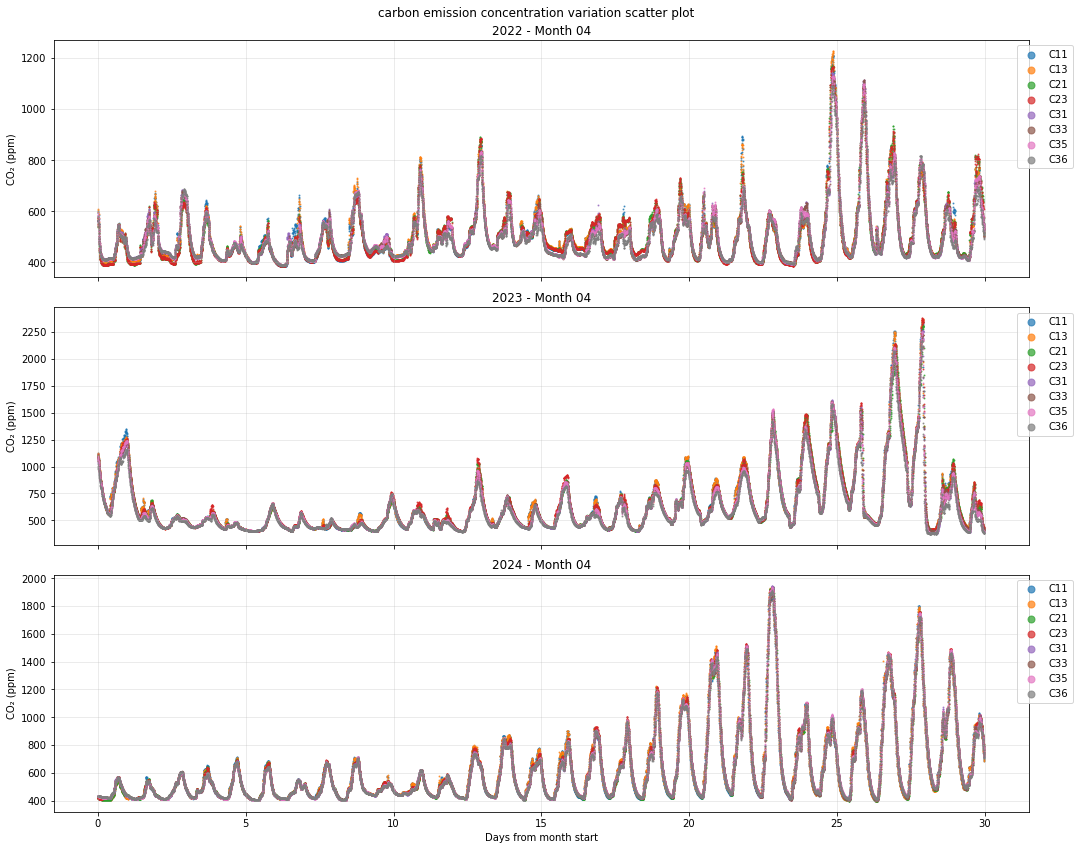


=== Month 04 ===

2022:
  C13:  0.0% NaN, occurs between(04-30 23:55 to 04-30 23:55)
  C21:  0.0% NaN, occurs between(04-30 23:50 to 04-30 23:55)
  C23:  0.0% NaN, occurs between(04-30 23:55 to 04-30 23:55)
  Time gaps: 2 found
  04-01 01:55 -> 04-01 02:05 (0.2h)
  04-22 13:15 -> 04-22 13:25 (0.2h)

2023:
  C31:  0.0% NaN, occurs between(04-14 02:50 to 04-14 02:50)
  Time gaps: 1 found
  04-01 01:55 -> 04-01 02:05 (0.2h)

2024:
  Time gaps: 6 found
  04-02 01:55 -> 04-02 02:05 (0.2h)
  04-03 01:55 -> 04-03 02:05 (0.2h)
  04-04 01:55 -> 04-04 02:05 (0.2h)


In [52]:
plot_month_comparison_scatter("04")
analyze_missing_comprehensive("04") 

# Month 5

2022: 8913 records
2023: 6993 records
2024: 8750 records


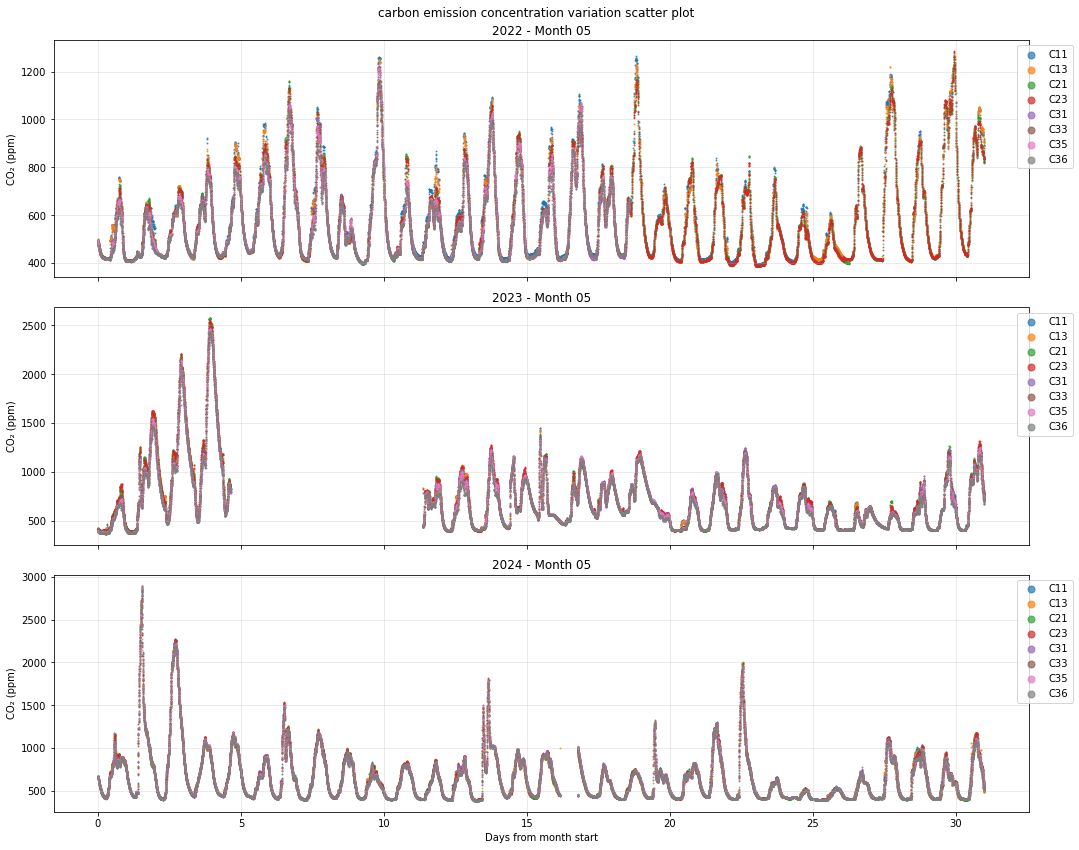


=== Month 05 ===

2022:
  C31:  40.1% NaN, occurs between(05-19 14:10 to 05-31 23:55)
  C33:  40.1% NaN, occurs between(05-19 14:05 to 05-31 23:55)
  C35:  40.1% NaN, occurs between(05-19 14:00 to 05-31 23:55)
  C36:  40.1% NaN, occurs between(05-19 13:55 to 05-31 23:55)
  Time gaps: 3 found
  05-03 12:55 -> 05-03 13:50 (0.9h)
  05-03 15:45 -> 05-03 16:10 (0.4h)
  05-04 09:10 -> 05-04 09:25 (0.2h)

2023:
  C13:  0.0% NaN, occurs between(05-02 07:20 to 05-02 07:20)
  C36:  0.0% NaN, occurs between(05-01 13:30 to 05-01 13:30)
  Time gaps: 1 found
  05-05 15:15 -> 05-12 08:40 (161.4h)

2024:
  Time gaps: 1 found
  05-17 03:25 -> 05-17 18:25 (15.0h)


In [53]:
plot_month_comparison_scatter("05")
analyze_missing_comprehensive("05") 

# Month 6

2022: 8417 records
2023: 8640 records
2024: 8391 records


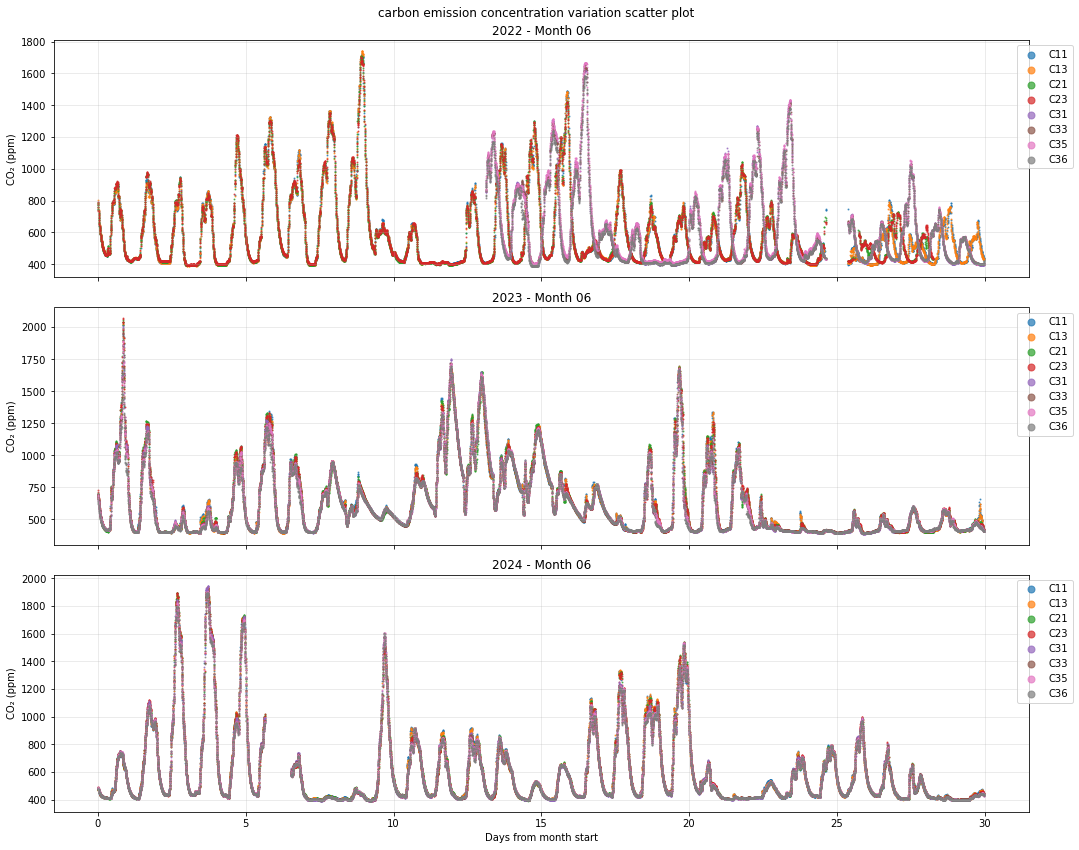


=== Month 06 ===

2022:
  C13:  0.2% NaN, occurs between(06-25 13:25 to 06-30 23:55)
  C21:  6.6% NaN, occurs between(06-26 13:10 to 06-30 23:55)
  C23:  6.6% NaN, occurs between(06-26 13:15 to 06-30 23:55)
  C31:  44.9% NaN, occurs between(06-01 00:00 to 06-14 02:50)
  C33:  44.9% NaN, occurs between(06-01 00:00 to 06-14 02:50)
  C35:  44.9% NaN, occurs between(06-01 00:00 to 06-14 02:50)
  C36:  44.9% NaN, occurs between(06-01 00:00 to 06-14 02:45)
  Time gaps: 2 found
  06-26 12:35 -> 06-26 12:40 (1.1h)
  06-29 00:25 -> 06-29 00:30 (18.1h)

2023:
  C21:  0.0% NaN, occurs between(06-17 19:10 to 06-17 19:10)
  C23:  0.0% NaN, occurs between(06-14 18:15 to 06-17 02:05)

2024:
  C13:  0.0% NaN, occurs between(06-06 15:25 to 06-30 23:55)
  C21:  0.0% NaN, occurs between(06-07 12:25 to 06-07 12:25)
  C23:  0.0% NaN, occurs between(06-07 12:25 to 06-07 12:25)
  C36:  0.0% NaN, occurs between(06-06 15:25 to 06-06 15:25)
  Time gaps: 1 found
  06-08 03:40 -> 06-08 03:45 (21.0h)


In [54]:
plot_month_comparison_scatter("06")
analyze_missing_comprehensive("06") 

# Month 7

2022: 8127 records
2023: 8196 records
2024: 7055 records


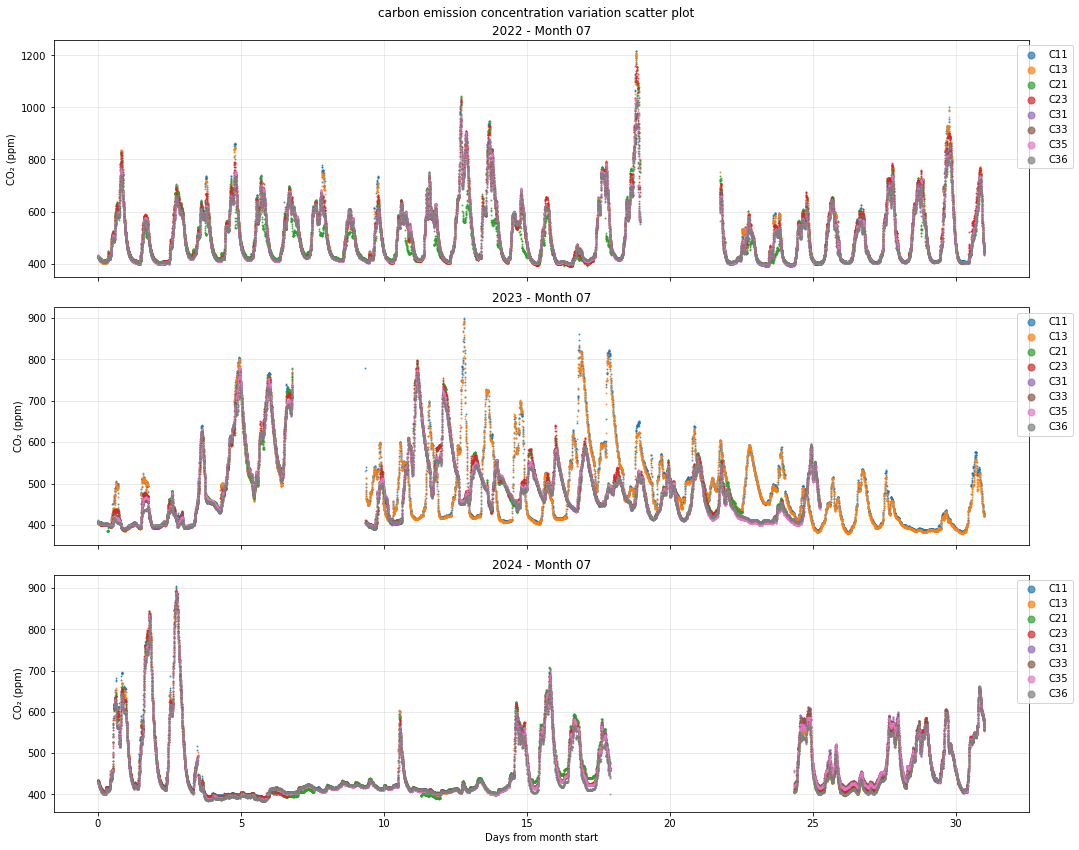


=== Month 07 ===

2022:
  Time gaps: 1 found
  07-19 22:45 -> 07-22 17:35 (66.8h)

2023:
  C13:  0.0% NaN, occurs between(07-07 19:10 to 07-31 23:55)
  C21:  20.2% NaN, occurs between(07-26 05:45 to 07-31 23:55)
  C23:  20.2% NaN, occurs between(07-26 06:05 to 07-31 23:55)
  C31:  20.3% NaN, occurs between(07-26 05:40 to 07-31 23:55)
  C33:  20.3% NaN, occurs between(07-26 05:40 to 07-31 23:55)
  C35:  20.3% NaN, occurs between(07-06 02:20 to 07-31 23:55)
  C36:  20.2% NaN, occurs between(07-26 05:45 to 07-31 23:55)
  Time gaps: 1 found
  07-18 15:45 -> 07-18 15:50 (61.2h)

2024:
  C13:  0.0% NaN, occurs between(07-15 19:55 to 07-15 19:55)
  C21:  0.0% NaN, occurs between(07-15 21:35 to 07-15 22:45)
  C31:  0.0% NaN, occurs between(07-15 22:05 to 07-15 22:05)
  C36:  0.0% NaN, occurs between(07-15 21:35 to 07-31 23:55)
  Time gaps: 4 found
  07-04 11:00 -> 07-04 12:10 (1.2h)
  07-15 22:40 -> 07-15 22:45 (0.5h)
  07-15 23:00 -> 07-15 23:05 (0.2h)


In [55]:
plot_month_comparison_scatter("07")
analyze_missing_comprehensive("07") 

# Month 8

2022: 8928 records
2023: 8932 records
2024: 8807 records


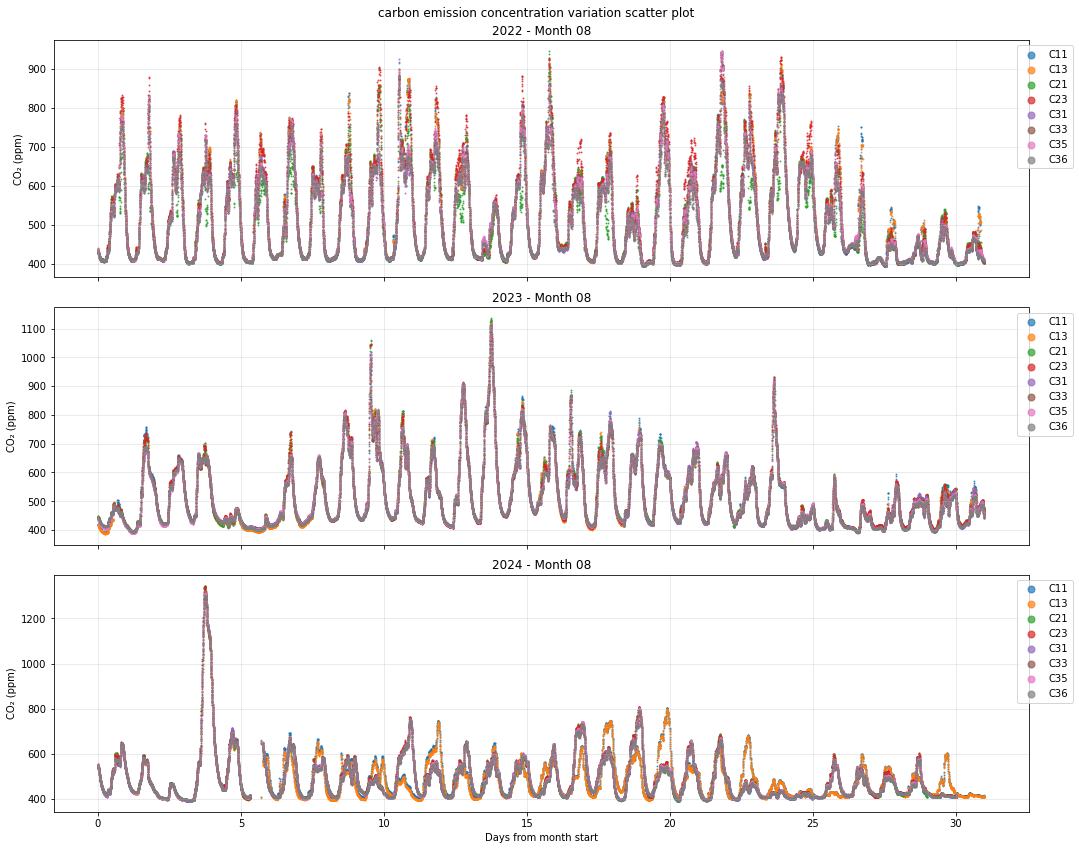


=== Month 08 ===

2022:
  No missing data

2023:
  C13:  0.0% NaN, occurs between(08-31 23:40 to 08-31 23:55)
  C23:  0.0% NaN, occurs between(08-31 23:55 to 08-31 23:55)
  C31:  0.0% NaN, occurs between(08-31 23:40 to 08-31 23:55)
  C33:  0.0% NaN, occurs between(08-02 02:10 to 08-31 23:55)
  C35:  0.0% NaN, occurs between(08-31 23:45 to 08-31 23:55)
  C36:  0.0% NaN, occurs between(08-05 01:30 to 08-31 23:55)

2024:
  C13:  0.0% NaN, occurs between(08-31 23:55 to 08-31 23:55)
  C21:  3.2% NaN, occurs between(08-31 00:30 to 08-31 23:55)
  C23:  3.2% NaN, occurs between(08-31 00:30 to 08-31 23:55)
  C31:  3.2% NaN, occurs between(08-31 00:35 to 08-31 23:55)
  C33:  3.2% NaN, occurs between(08-31 00:30 to 08-31 23:55)
  C35:  3.2% NaN, occurs between(08-31 00:40 to 08-31 23:55)
  C36:  3.2% NaN, occurs between(08-31 00:40 to 08-31 23:55)
  Time gaps: 2 found
  08-08 03:40 -> 08-08 03:45 (9.2h)
  08-08 03:45 -> 08-08 03:50 (1.1h)


In [56]:
plot_month_comparison_scatter("08")
analyze_missing_comprehensive("08") 

# Month 9

2022: 8631 records
2023: 8505 records
2024: 8469 records


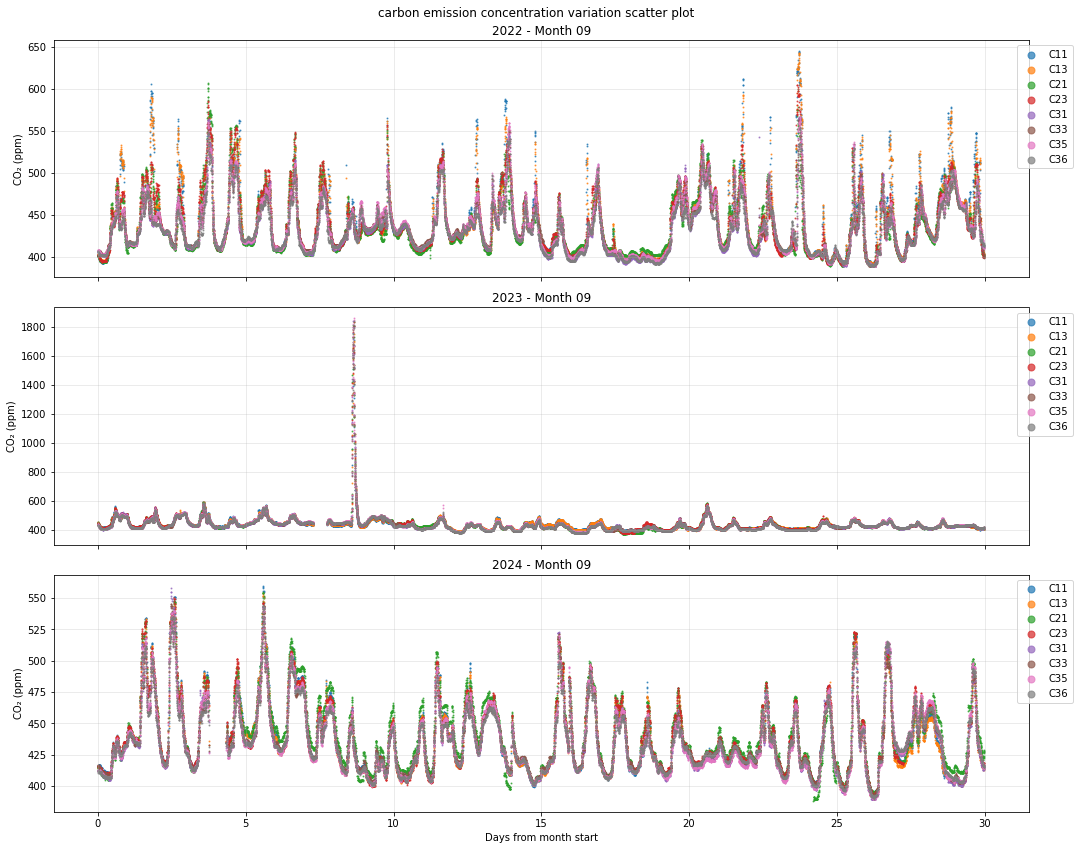


=== Month 09 ===

2022:
  C23:  0.0% NaN, occurs between(09-30 23:55 to 09-30 23:55)
  Time gaps: 9 found
  09-11 22:45 -> 09-11 22:55 (0.2h)
  09-12 22:45 -> 09-12 22:55 (0.2h)
  09-13 22:45 -> 09-13 22:55 (0.2h)

2023:
  Time gaps: 1 found
  09-08 06:35 -> 09-08 17:55 (11.3h)

2024:
  C21:  0.0% NaN, occurs between(09-30 23:55 to 09-30 23:55)
  C31:  0.0% NaN, occurs between(09-30 23:55 to 09-30 23:55)
  Time gaps: 1 found
  09-04 17:50 -> 09-05 08:15 (14.4h)


In [57]:
plot_month_comparison_scatter("09")
analyze_missing_comprehensive("09") 

# Month 10

2022: 8935 records
2023: 7227 records
2024: 8666 records


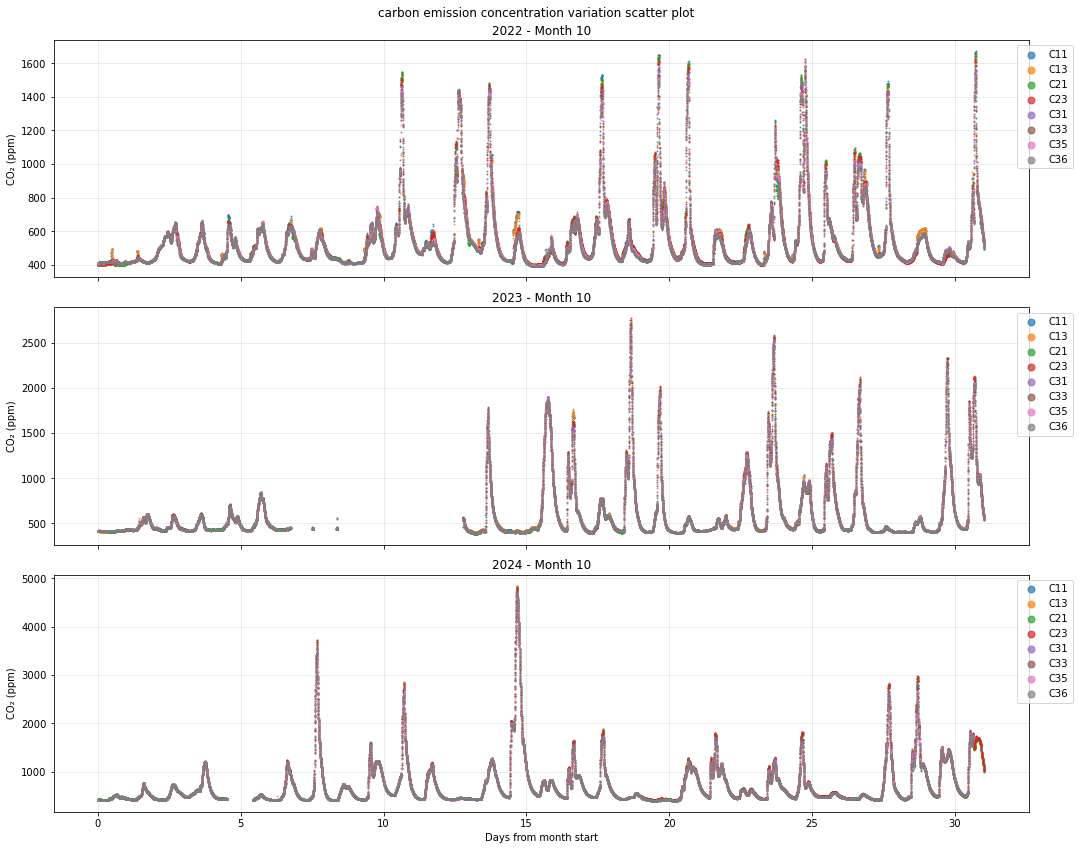


=== Month 10 ===

2022:
  C13:  0.0% NaN, occurs between(10-25 08:40 to 10-25 08:40)
  C23:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  C33:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  C36:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  Time gaps: 1 found
  10-09 11:50 -> 10-09 12:20 (0.5h)

2023:
  C13:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  C33:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  C35:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  C36:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  Time gaps: 3 found
  10-07 17:50 -> 10-08 12:05 (18.2h)
  10-08 12:50 -> 10-09 08:20 (19.5h)
  10-09 09:15 -> 10-13 18:35 (105.3h)

2024:
  C13:  0.0% NaN, occurs between(11-01 00:55 to 11-01 00:55)
  C31:  1.4% NaN, occurs between(10-31 15:15 to 11-01 00:55)
  C33:  1.4% NaN, occurs between(10-31 15:15 to 11-01 00:55)
  C35:  1.3% NaN, occurs between(10-31 15:20 to 11-01 00:55)
  C36:  1.3% NaN, occurs between(10-31 

In [65]:
plot_month_comparison_scatter("10")
analyze_missing_comprehensive("10") 

# Month 11

2022: 8641 records
2023: 3493 records
2024: 8536 records


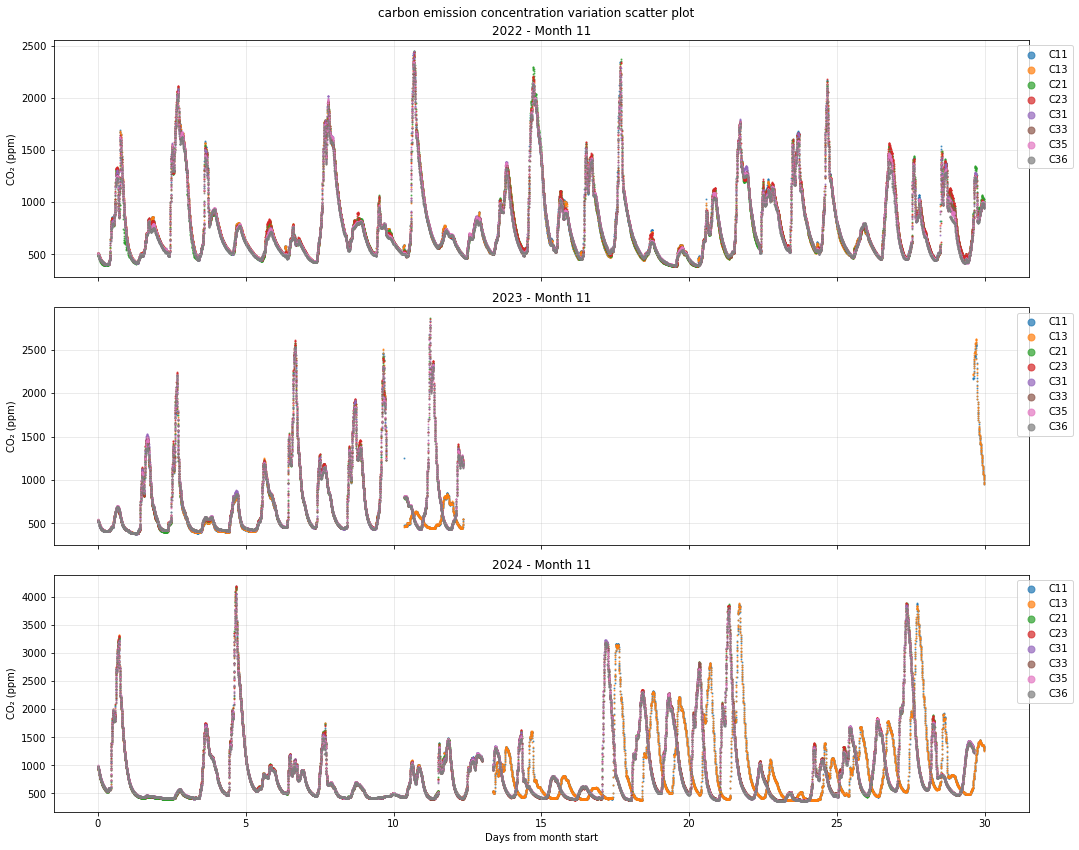


=== Month 11 ===

2022:
  C13:  0.0% NaN, occurs between(11-14 10:35 to 11-14 10:35)

2023:
  C13:  0.1% NaN, occurs between(11-10 17:55 to 11-30 23:55)
  C21:  3.1% NaN, occurs between(11-30 14:50 to 11-30 23:55)
  C23:  3.1% NaN, occurs between(11-30 14:50 to 11-30 23:55)
  C31:  3.1% NaN, occurs between(11-30 14:50 to 11-30 23:55)
  C33:  3.1% NaN, occurs between(11-30 14:50 to 11-30 23:55)
  C35:  3.1% NaN, occurs between(11-30 14:50 to 11-30 23:55)
  C36:  3.1% NaN, occurs between(11-30 14:50 to 11-30 23:55)
  Time gaps: 2 found
  11-30 15:20 -> 11-30 15:25 (14.8h)

2023: Error - single positional indexer is out-of-bounds

2024:
  C13:  0.0% NaN, occurs between(11-30 23:55 to 11-30 23:55)
  C21:  1.2% NaN, occurs between(11-30 15:20 to 11-30 23:55)
  C23:  1.2% NaN, occurs between(11-30 15:15 to 11-30 23:55)
  C31:  1.2% NaN, occurs between(11-30 15:10 to 11-30 23:55)
  C33:  1.2% NaN, occurs between(11-30 15:20 to 11-30 23:55)
  C35:  1.2% NaN, occurs between(11-30 15:15 to 11-3

In [66]:
plot_month_comparison_scatter("11")
analyze_missing_comprehensive("11") 

# Month 12

2022: 6962 records
2023: 7740 records
2024: 8928 records


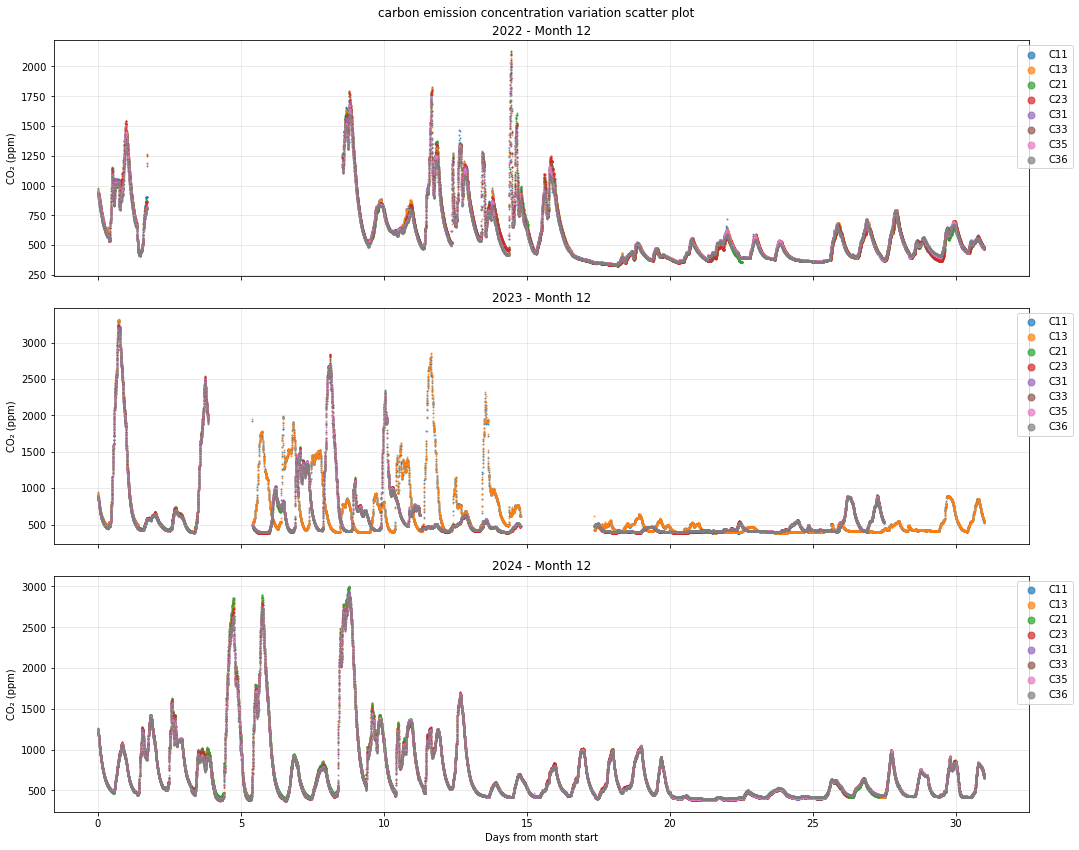


=== Month 12 ===

2022:
  C21:  0.0% NaN, occurs between(12-31 23:55 to 12-31 23:55)
  C31:  0.1% NaN, occurs between(12-31 23:20 to 12-31 23:55)
  C33:  0.1% NaN, occurs between(12-28 22:30 to 12-31 23:55)
  C35:  0.1% NaN, occurs between(12-31 23:15 to 12-31 23:55)
  C36:  0.1% NaN, occurs between(12-31 23:25 to 12-31 23:55)
  Time gaps: 1 found
  12-02 16:55 -> 12-09 13:00 (164.1h)

2023:
  C21:  13.0% NaN, occurs between(12-28 11:55 to 12-31 23:55)
  C23:  13.1% NaN, occurs between(12-28 11:45 to 12-31 23:55)
  C31:  13.1% NaN, occurs between(12-28 11:35 to 12-31 23:55)
  C33:  13.1% NaN, occurs between(12-28 11:45 to 12-31 23:55)
  C35:  13.1% NaN, occurs between(12-28 11:35 to 12-31 23:55)
  C36:  13.1% NaN, occurs between(12-28 11:35 to 12-31 23:55)
  Time gaps: 2 found
  12-11 11:05 -> 12-11 11:10 (37.3h)
  12-23 10:00 -> 12-23 10:05 (61.9h)

2024:
  No missing data


In [60]:
plot_month_comparison_scatter("12")
analyze_missing_comprehensive("12") 

In summary:
- **Mouth 1**：**2022, 2023 and 2024 has large data gap(more than 44.9%)**

- **Mouth 2**：**2023 has medium data gap (more than 5%)**, 2022 and 2024 has minimal missing rate(less than 1%)

- **Month 3**:   2022 has **large data gap (more than 71%)**; 2023 and 2024 minimal missing rate (less than 1%)

- **Mouth 4**：minimal missing rate, less than 1% for three years

- **Mouth 5**：**2023 has large data gap(more than 41%),2023 has large time gap**; 2024 has **15h** missing time gap

- **Mouth 6**：**2022 has large data gap(more than 44.9%)**;2024 has **18h** time gap,2 023 has minimal missing rate (less than 1%)

- **Mouth 7**：**2022, 2023 and 2024 has large data gap(more than 44.9%)**

- **Mouth 8**：**2024 has medium missing data (round 3.2%)**, 2022 and 2023 has minimal missing rate, less than 1%.

- **Mouth 9**：2023 and 2024 have around **10 h** time gap.2022 has minimal missing rate, less than 1% for three years

- **Mouth 10**: 2023 has large time gap around **105.3h** minimal missing rate; 2023 and 2024 have less than 1% for three years

- **Mouth 11**：

- **Mouth 12**：**2022 and 2023 has large time gap(more than 100 hours)**; 2024 has non minimal missing rate 


Missing correlation:
- **Group A**: C31, C33, C35, C36 (always missing together)
- **Group B**: C21, C23 (sometime missing with Group A)
- **Group C**: C11, C13 (relatively independent)

# Missing data handling

Due to various reasons, databases frequently have some gaps caused by missing data. The inability to evaluate and manage missing data will greatly impede the the subsequent work of in-depth analysis and data mining. Hybrid large gap strategy is adopted in this cased based on the period of missing data.

Interpolation is one of the most capable method in datasets with a low missing rate. This step focuses on **handling small missing data gaps** (less than 1 hour) in our monthly CO₂ sensor data. Linear interpolation is acceptable for these small gaps, but not for larger missing periods.

In [218]:
#define simple interpolation function for missing data
def interpolate_missing_data(month, year):
    df = pd.read_feather(f'../Data/CO2/CO2_{month}_{year}.feather')
    df_processed = df.copy()
    co2_sensors = [col for col in df.columns if col.startswith('C')]

    for sensor in co2_sensors:
        s = df_processed[sensor]
        # missing（True）or non-missing（False）
        is_nan = s.isna()

        # 分组标记连续缺失段
        gap_id = (is_nan != is_nan.shift()).cumsum()
        gaps = is_nan.groupby(gap_id).apply(lambda g: len(g) if g.iloc[0] else 0)

        # only interpolation for less than 12 gap(1h)
        max_gap = gaps.max()
        if max_gap <= 12:
            df_processed[sensor] = s.interpolate(method='linear')

    return df_processed

#apply to all month in three years
months = [f"{i:02d}" for i in range(1, 13)]
years = ["2022", "2023", "2024"]

for month in months:
    for year in years:
        df_processed = interpolate_missing_data(month, year)

Considering the **spatial correlations** between sensors in the same ventilated space, the potential of employing inter-sensor regression  should be considered for larger data missing rate cases.

- It has shown that C31, C33 and C35 have high corrations. However, by observating the records of the missing data time, the results shows that they experience **missing data nearly simultaneously**.
- if it is possible for us to choose the secondary corrations senser,like C35 and C23? and then do the regression fucntion?

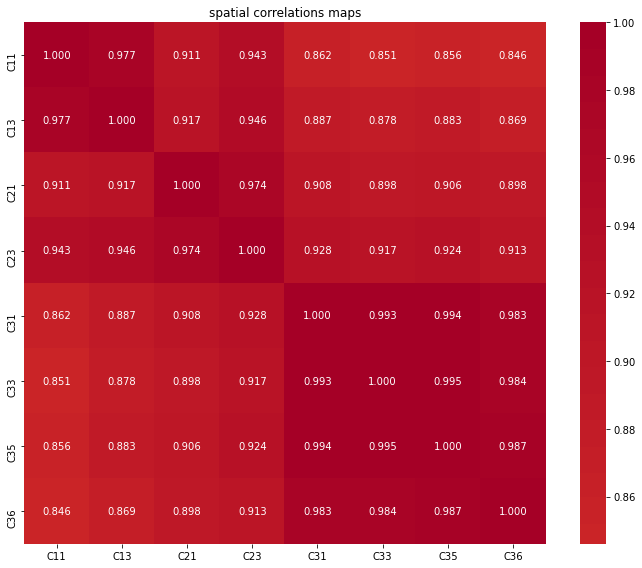


C11:
  highest correlations: C13 (0.977)
  lowest correlations: C36 (0.846)
  average correlations: 0.892

C13:
  highest correlations: C11 (0.977)
  lowest correlations: C36 (0.869)
  average correlations: 0.908

C21:
  highest correlations: C23 (0.974)
  lowest correlations: C36 (0.898)
  average correlations: 0.916

C23:
  highest correlations: C21 (0.974)
  lowest correlations: C36 (0.913)
  average correlations: 0.935

C31:
  highest correlations: C35 (0.994)
  lowest correlations: C11 (0.862)
  average correlations: 0.936

C33:
  highest correlations: C35 (0.995)
  lowest correlations: C11 (0.851)
  average correlations: 0.931

C35:
  highest correlations: C33 (0.995)
  lowest correlations: C11 (0.856)
  average correlations: 0.935

C36:
  highest correlations: C35 (0.987)
  lowest correlations: C11 (0.846)
  average correlations: 0.926


In [147]:
def analyze_sensor_correlations(df):
    co2_sensors = [col for col in df.columns if col.startswith('C')]
    
    corr_matrix = df[co2_sensors].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
                square=True, fmt='.3f')
    plt.title('spatial correlations maps')
    plt.tight_layout()
    plt.show()

    
 #calculate the maximum,lowest and average correlation for each sensors
    for sensor in co2_sensors:
        correlations = corr_matrix[sensor].drop(sensor)  # remove itself
        print(f"\n{sensor}:")
        print(f"  highest correlations: {correlations.idxmax()} ({correlations.max():.3f})")
        print(f"  lowest correlations: {correlations.idxmin()} ({correlations.min():.3f})")
        print(f"  average correlations: {correlations.mean():.3f}")
    
    return corr_matrix

#test
corr_matrix = analyze_sensor_correlations(df)

The alternertive option is time correlation.This step calculates the **temporal correlation** between different CO₂ sensors.  Specifically, it compares how each sensor's **hourly average pattern** (0–23 hours) correlates with others. This helps reveal whether some sensors experience similar daily cycles, which might reflect shared occupancy effects or common ventilation dynamics. 

Firstly have a general look of daily concentration variation. It can be seen that there is a clear variation pattern for all sensors.Starting around 6–7 am, CO₂ levels begin to rise steadily. After 3 PM, concentrations gradually decrease for sensors.  it’s notable that some sensors (particularly C11 and C13) show a **secondary increase** in CO₂ concentrations after 5-6 PM. Sensors like C11 and C13 tend to show the highest peak concentrations.  C35 and C36 generally report lower overall values, possibly reflecting placement closer to ventilation inlets.

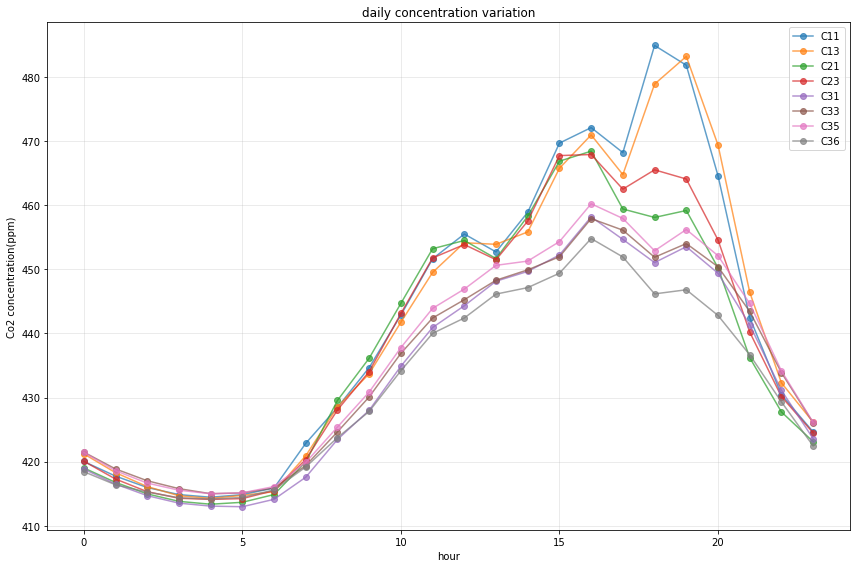

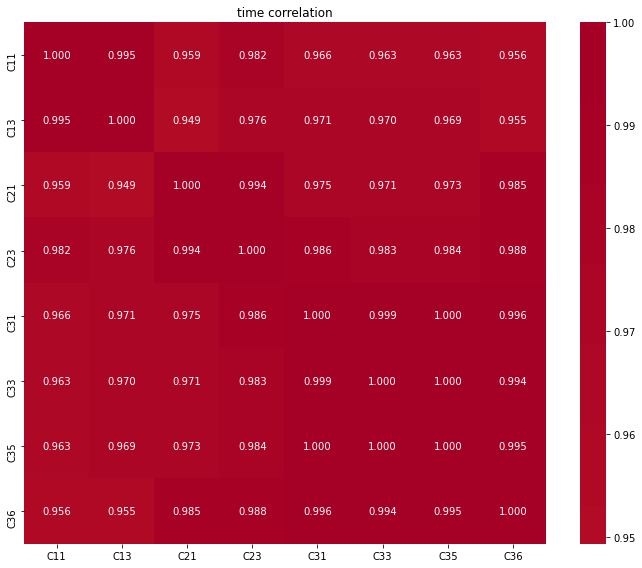


C11:
  highest correlations: C13 (0.977)
  lowest correlations: C36 (0.846)
  average correlations: 0.892

C13:
  highest correlations: C11 (0.977)
  lowest correlations: C36 (0.869)
  average correlations: 0.908

C21:
  highest correlations: C23 (0.974)
  lowest correlations: C36 (0.898)
  average correlations: 0.916

C23:
  highest correlations: C21 (0.974)
  lowest correlations: C36 (0.913)
  average correlations: 0.935

C31:
  highest correlations: C35 (0.994)
  lowest correlations: C11 (0.862)
  average correlations: 0.936

C33:
  highest correlations: C35 (0.995)
  lowest correlations: C11 (0.851)
  average correlations: 0.931

C35:
  highest correlations: C33 (0.995)
  lowest correlations: C11 (0.856)
  average correlations: 0.935

C36:
  highest correlations: C35 (0.987)
  lowest correlations: C11 (0.846)
  average correlations: 0.926


In [194]:
def compare_temporal_patterns_all_sensors(df):
    co2_sensors = [col for col in df.columns if col.startswith('C')]
    
    all_hourly_stats = {}
    
    for sensor in co2_sensors:
        df_temp = df.copy() # not change the origial file
        df_temp['hour'] = df_temp['Time'].dt.hour
        hourly_stats = df_temp.groupby('hour')[sensor].mean()
        all_hourly_stats[sensor] = hourly_stats

    plt.figure(figsize=(12, 8))
    
    for sensor in co2_sensors:
        plt.plot(all_hourly_stats[sensor].index, 
                all_hourly_stats[sensor].values, 
                label=sensor, marker='o', alpha=0.7)
    
    plt.title('daily concentration variation')
    plt.xlabel('hour')
    plt.ylabel('Co2 concentration(ppm)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    
#Calculate temporal correlation
    pattern_correlations = pd.DataFrame(all_hourly_stats).corr()#correlation of different senesor concentration variation in 24h 
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pattern_correlations, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, fmt='.3f')
    plt.title('time correlation')
    plt.tight_layout()
    plt.show()
        
    for sensor in co2_sensors:
        correlations = corr_matrix[sensor].drop(sensor)  # remove itself
        print(f"\n{sensor}:")
        print(f"  highest correlations: {correlations.idxmax()} ({correlations.max():.3f})")
        print(f"  lowest correlations: {correlations.idxmin()} ({correlations.min():.3f})")
        print(f"  average correlations: {correlations.mean():.3f}")
    
    return pattern_correlations

pattern_corr = compare_temporal_patterns_all_sensors(df)